In [60]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Turn csv into dataframe and select the first 8 features as asked
accounts_df = pd.read_csv('accounts.csv')
accounts_df = accounts_df.iloc[:, :8]
print(f'Selected features:\n{accounts_df.columns}\n')

################################### PRE PROCESSING ###################################

# Check for duplicates
print(f'Duplicates: {accounts_df.duplicated().sum()}\n')
print(f'Missings: \n{accounts_df.isnull().sum()}\n')
# Remove duplicates and rows with missing values, even though there aren't any of the latter, just to make sure.
accounts_df = accounts_df.drop_duplicates()
accounts_df = accounts_df.dropna()

accounts_df_pre_dummification = accounts_df.copy() # useful for last exercise

################################### DUMMIFICATION ###################################

# Display unupdated data frame
print(f'Data prior to converting categorical features:\n{accounts_df.head()}\n')

# Dummify
accounts_df = pd.get_dummies(accounts_df, drop_first=True).astype('float')

# Display the updated DataFrame
print(f'Data after converting categorical features:\n{accounts_df.head()}\n')


############################### MIN-MAX NORMALIZATION ###############################

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(accounts_df)

# Convert the normalized data back to a DataFrame for easier handling
accounts_df_normalized = pd.DataFrame(normalized_data, columns=accounts_df.columns)

# Display the normalized data
print(f'Normalized accounts data:\n{accounts_df_normalized.head()}\n')

Selected features:
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan'],
      dtype='object')

Duplicates: 846

Missings: 
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
dtype: int64

Data prior to converting categorical features:
   age         job  marital  education default  balance housing loan
0   59      admin.  married  secondary      no     2343     yes   no
1   56      admin.  married  secondary      no       45      no   no
2   41  technician  married  secondary      no     1270     yes   no
3   55    services  married  secondary      no     2476     yes   no
4   54      admin.  married   tertiary      no      184      no   no

Data after converting categorical features:
    age  balance  job_blue-collar  job_entrepreneur  job_housemaid  \
0  59.0   2343.0              0.0               0.0            0.0   
1  56.0     45.0              0.0               0.0     

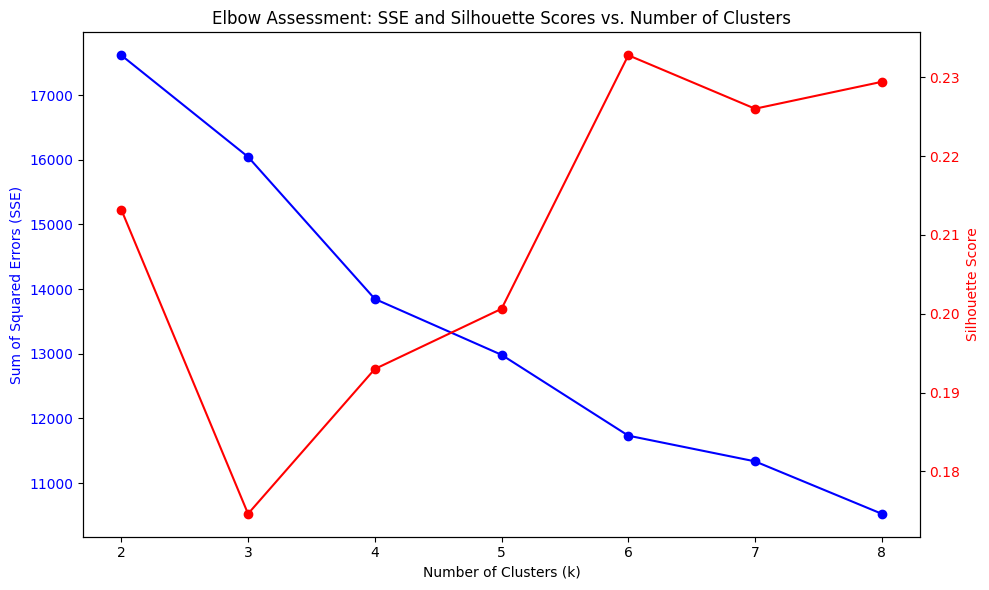

In [61]:
############################### 1 ###############################~

# Set up parameters for clustering
k_values = range(2, 9)
sse = []
silhouette_scores = []

# For each k, initialize model, train it, and append the sum of squared errors
for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42)
    kmeans.fit(accounts_df_normalized)
    sse.append(kmeans.inertia_)

# Calculate silhouette score for each k. This is made in another loop to not interfere with the fitting of the kmeans made previously
for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42)
    labels = kmeans.fit_predict(accounts_df_normalized)
    silhouette_scores.append(silhouette_score(accounts_df_normalized, labels))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot SSE
ax1.plot(k_values, sse, marker='o', color='b', label='SSE')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Sum of Squared Errors (SSE)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for silhouette scores
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, marker='o', color='r', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legend
plt.title('Elbow Assessment: SSE and Silhouette Scores vs. Number of Clusters')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The blue graph is not very suggestive, as it is very linear. We considered another method, based on the slides, which is finding the k that maximizes the silhouette, just as complementary aid.

Based on the plots, the optimal number of underlying customer segments appears to be k=6. While the Sum of Squared Errors (SSE) decreases linearly with increasing k, indicating better fitting and lower inertia, this trend also suggests a risk of overfitting, where additional clusters may not lead to meaningful segments. Since from k=2 to k=4, we see a decrease of SSE of about 3000; from k=4 to k=6 we see a decrease of about 2000, and from k=6 onwards we see a decrease of barely 1000, we suspect the elbow might start around k=6, thus selecting this k as the optimal value.

The silhouette score peaks at  k=6, suggesting this configuration balances cluster separation and inertia effectively. Although the silhouette score at this point is near 0, indicating some overlap between clusters, as we'll see later on, it is the highest score we achieved, suggesting that six clusters provide the best trade-off between adequately capturing customer segments and maintaining model simplicity.

This response clearly identifies k=6 as the recommended number of clusters and explains the trade-off between cluster number and inertia.


Given that our dataset primarily consists of categorical features, using K-Modes instead of K-Means would likely be more effective for clustering. K-Means relies on Euclidean distance, which is not suitable for categorical data, whereas K-Modes employs Hamming distance, making it better suited for the feature set. Additionally, the dummification process significantly increased the dimensionality of your dataset, as seen by the prints we employed previously, leading to the 'curse of dimensionality', where the distance between points becomes less meaningful, and a less optimized algorithm. K-Modes directly works with categorical variables, avoiding the complexities of dummy variable traps and providing more intuitive cluster centroids based on the most frequent categories. This not only improves the interpretability of the resulting clusters but also enhances clustering performance, leading to more accurate customer segmentations that truly reflect the underlying data.

In [51]:
###################################### 2 ######################################

###################################### STANDARD SCALER NORMALIZATION ######################################
scaler = StandardScaler()
normalized_data_std = scaler.fit_transform(accounts_df)

# Apply pca to normalized data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data_std)
accounts_df_normalized_std = pd.DataFrame(normalized_data, columns=accounts_df.columns)

# How much variability is explained by the top 2 components printed
explained_variance = pca.explained_variance_ratio_

# Print the explained variance
print(f'Variance explained by the first component: {explained_variance[0]:.2f}')
print(f'Variance explained by the second component: {explained_variance[1]:.2f}')
print(f'Total variance explained by the top 2 components: {explained_variance.sum():.2f}')

Variance explained by the first component: 0.12
Variance explained by the second component: 0.11
Total variance explained by the top 2 components: 0.23


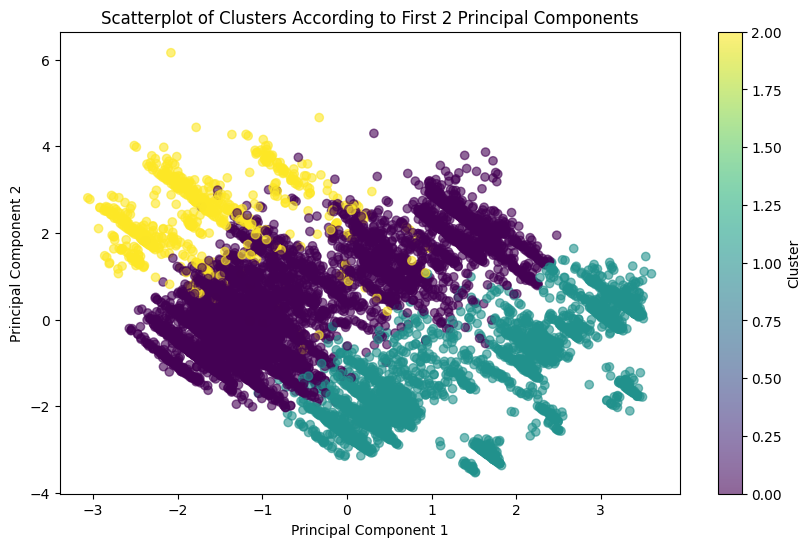

In [62]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# kmeans initialization and fitting
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(normalized_data_std) # wew will add these later for the plots 

# Apply PCA to reduce the data to 2 principal components for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data_std)

# Create a DataFrame for PCA results for plot
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = labels  # Add the cluster labels to the PCA DataFrame

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of Clusters According to First 2 Principal Components')
plt.colorbar(scatter, label='Cluster')
plt.show()

In the scatterplot above, we see that the clusters generated by K-means with k=3 are somewhat overlapping, indicating that the separation between clusters is not entirely clear. While there are areas with a concentration of certain clusters (for example, the yellow cluster in the upper left and the teal cluster towards the lower right), significant overlap exists, especially in the central region. This suggests that the data might not naturally form well-separated clusters in the space defined by the first two principal components, or that a higher value of k might be needed to achieve more distinct clusters.

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan'],
      dtype='object')
[0 0 0 ... 0 1 0]


<Figure size 1200x600 with 0 Axes>

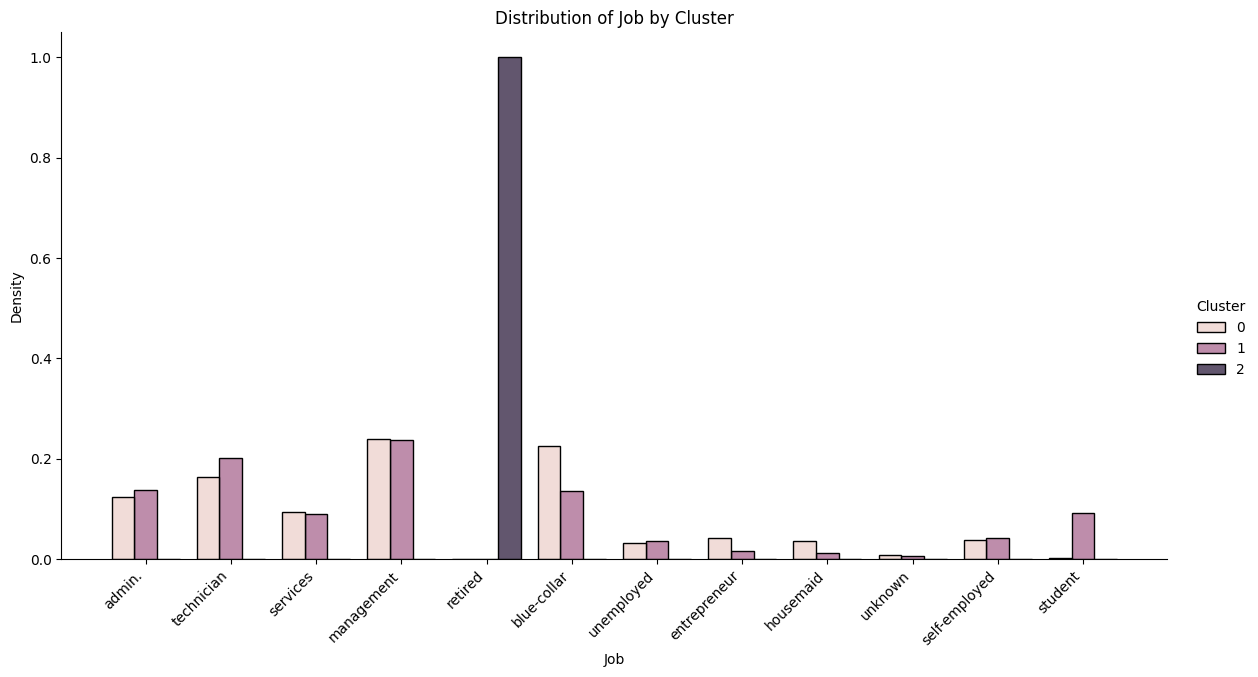

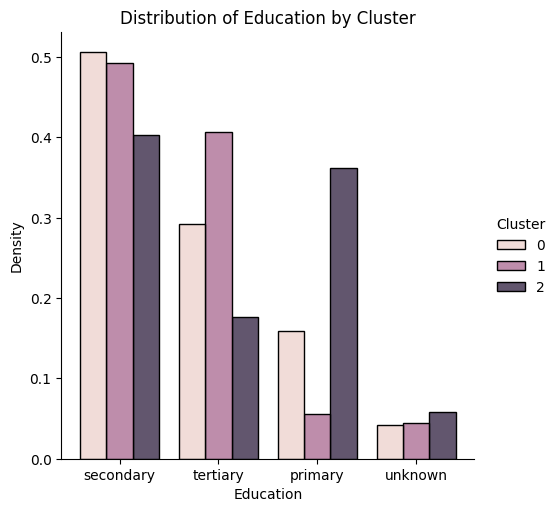

In [63]:
import seaborn as sns
# Add cluster labels to the original dataframe
print(accounts_df_pre_dummification.columns)
accounts_df_pre_dummification['Cluster'] = labels  # add labels from previous coding block to the accounts dataframe (plot)
print(labels)

# Plot for job
plt.figure(figsize=(12, 6))
sns.displot(data=accounts_df_pre_dummification, x='job', hue='Cluster', multiple='dodge', stat='density', shrink=0.8, common_norm=False, height=6, aspect=2)
plt.title('Distribution of Job by Cluster')
plt.xlabel('Job')
plt.ylabel('Density')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Plot for edu
sns.displot(data=accounts_df_pre_dummification, x='education', hue='Cluster', multiple='dodge', stat='density', shrink=0.8, common_norm=False)
plt.title('Distribution of Education by Cluster')
plt.xlabel('Education')
plt.ylabel('Density')
plt.show()
